# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



# 1. Dataset Overview and PreProcessing



### Problem Statement:
The task is to predict the probability that an online transaction is fraudulent using identity and transaction data.

### Dataset Description:
- **Target variable:** `isFraud` (1 = fraud, 0 = not fraud)
- **Files:** `train_transaction.csv`, `train_identity.csv` (joined on `TransactionID`)
- **Features:**  
  - *Transaction Data:* ProductCD, card1–card6, addr1, addr2, M1–M9  
  - *Identity Data:* DeviceType, DeviceInfo, id_12–id_38  
- The feature `TransactionDT` is a relative timestamp.


## 2. Defining all the Imports and necessary dependencies

In [94]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import Regularizer, l1, l2, l1_l2
from tensorflow.keras.optimizers import Optimizer, Adam, SGD, RMSprop,Nadam
from tensorflow.keras.callbacks import EarlyStopping

## Data PreProcessing

### 1. Loading and Merge Data

In [5]:
# Load datasets
train_transaction = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [6]:
# Merge on TransactionID
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Separate target
y = train_df['isFraud']
X = train_df.drop(columns=['isFraud', 'TransactionID'])

### 2. Outlier Clipping

In [7]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        self.lower = Q1 - self.factor * (Q3 - Q1)
        self.upper = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # Clip values
        X_clipped = X.clip(lower=self.lower, upper=self.upper, axis=1)
        return X_clipped.values

### 3. Feature Grouping

In [8]:
# Identifying features by type
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=[np.number]).columns.tolist()

low_card = [col for col in categorical if X[col].nunique() < 10]
high_card = list(set(categorical) - set(low_card))

### 4. PreProcessing Pipeline

In [9]:
# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clipper', OutlierClipper()),
    ('scaler', StandardScaler())
])

low_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

high_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Full transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical),
    ('low_cat', low_cat_pipeline, low_card),
    ('high_cat', high_cat_pipeline, high_card)
])

### 5. Data Splitting

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# variance thresholding
selector = VarianceThreshold(threshold=0.0001)
X_train_processed = selector.fit_transform(X_train_processed)
X_val_processed = selector.transform(X_val_processed)
X_test_processed = selector.transform(X_test_processed)

# SECTION 1: A Classification Model

### Light GBM Classification Model 1:
This LightGBM model is a gradient boosting classifier tailored for imbalanced fraud detection. It is trained using 5,500 boosting rounds (n_estimators) with a moderate learning rate of 0.05 to ensure stable convergence. The maximum depth is limited to 8, and 64 leaves per tree are allowed to control complexity and prevent overfitting. The class_weight='balanced' setting automatically compensates for class imbalance. It uses all available CPU cores for efficient training and sets a fixed random seed for reproducibility.

In [11]:
# A LightGBM model with tuned hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=5500,# Number of boosting rounds (trees).
    learning_rate=0.05,# Step size shrinkage used to prevent overfitting.
    max_depth=8,# Maximum depth of each tree. Controls model complexity;
    num_leaves=64, # Maximum number of leaves per tree.
    class_weight='balanced',# Automatically adjusts weights inversely proportional to class frequencies, helping with class imbalance.
    random_state=42,# Sets seed for reproducibility so results are consistent across runs.
    n_jobs=-1 # Uses all available CPU cores for training (parallel processing).
)

lgb_model.fit(X_train_processed, y_train)

# Saving the trained model
dump(lgb_model, 'saved_models/lightgbm_model.joblib')

[LightGBM] [Info] Number of positive: 14464, number of negative: 398899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4539
[LightGBM] [Info] Number of data points in the train set: 413363, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

['saved_models/lightgbm_model.joblib']

#### Model 1 Error analysis:

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


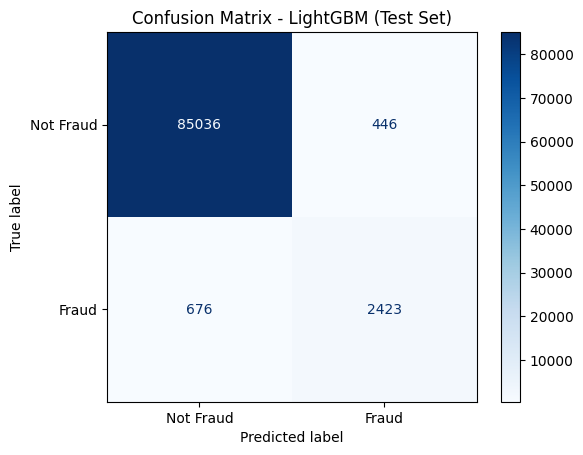

=== Classification Report (LightGBM - Test Set) ===
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99     85482
       Fraud       0.84      0.78      0.81      3099

    accuracy                           0.99     88581
   macro avg       0.92      0.89      0.90     88581
weighted avg       0.99      0.99      0.99     88581

True Negatives (TN): 85036
False Positives (FP): 446
False Negatives (FN): 676
True Positives (TP): 2423


In [12]:
# Predict probabilities and convert to binary labels (Test Set)
y_test_pred_prob = lgb_model.predict_proba(X_test_processed)[:, 1]
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM (Test Set)")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report (LightGBM - Test Set) ===")
print(report)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

## Model Architecture:

This is a deep neural Network Architecture that my model instances will all use each instance will have its own regularizers, optimization techiques but the core sturcture of the neural network will be the same. 6 hidden layers all using relu activation and one output layer using sigmoid activation to classify the data into either FRAUD or NOT FRAUD.

In [65]:
def build_model(input_dim, optimizer: Optimizer = None, regularizer: Regularizer = None, dropout_rates=None, use_batch_norm=False):
    """
    Builds a feedforward neural network with optional regularization, optimizer, dropout, and batch normalization.

    Parameters:
    - input_dim: int, number of input features
    - optimizer: keras.optimizers object (optional)
    - regularizer: keras.regularizers object (optional)
    - dropout_rates: list of float values or None. Length must match number of hidden layers.
    - use_batch_norm: bool, whether to apply BatchNormalization after each Dense layer.

    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    hidden_layers = [128, 64, 32, 16, 8]

    for i, units in enumerate(hidden_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizer))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=regularizer))
        
        if use_batch_norm:
            model.add(BatchNormalization())

        if dropout_rates and i < len(dropout_rates) and dropout_rates[i] > 0:
            model.add(Dropout(dropout_rates[i]))

    model.add(Dense(1, activation='sigmoid'))

    if optimizer:
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    return model


## Task: Define a function that creates models with or without specified Optimization techniques


### Neural Network Model Instance 1:
This is the first instance of the deep neura Network with no regularizers applied and Default optimizers applied.

In [37]:
model_1 = build_model(input_dim=X_train_processed.shape[1])


model_1.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    verbose=1
)

save_model(model_1, 'saved_models/nn_instance_1.keras')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12918/12918 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9704 - loss: 0.1131 - val_accuracy: 0.9728 - val_loss: 0.1044


#### Neural Network Model Instance 1 Error analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step


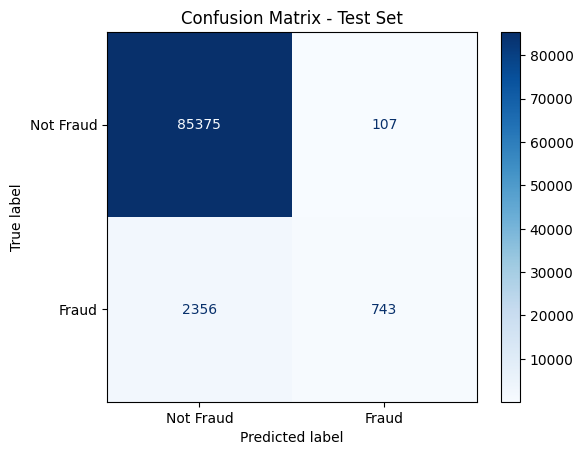

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.99     85482
       Fraud       0.87      0.24      0.38      3099

    accuracy                           0.97     88581
   macro avg       0.92      0.62      0.68     88581
weighted avg       0.97      0.97      0.96     88581

True Negatives (TN): 85375
False Positives (FP): 107
False Negatives (FN): 2356
True Positives (TP): 743


In [34]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_1.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Neural Network Model Instance 2:
Second instance now with my defined parameters and Hyperparameters. Used ADAM for optimization with a learning rate of 0.0001 and l2 regularization with a 0.0001 penalty also added early stopping on the valloss with a patience of 10. I also trained the model for 100 epochs with a 100 batch size.

In [71]:
model_2 = build_model(
    input_dim=X_train_processed.shape[1],
    optimizer=Adam(learning_rate=0.0001),
    regularizer=l2(0.0001)
)

history_2 = model_2.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_val_processed, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

save_model(model_2, 'saved_models/nn_instance_2.keras')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9473 - loss: 0.1913 - val_accuracy: 0.9722 - val_loss: 0.1193
Epoch 2/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9730 - loss: 0.1167 - val_accuracy: 0.9740 - val_loss: 0.1124
Epoch 3/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9741 - loss: 0.1101 - val_accuracy: 0.9743 - val_loss: 0.1082
Epoch 4/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9743 - loss: 0.1076 - val_accuracy: 0.9744 - val_loss: 0.1058
Epoch 5/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9745 - loss: 0.1057 - val_accuracy: 0.9750 - val_loss: 0.1034
Epoch 6/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9749 - loss: 0.1033 - val_accuracy: 0.9757 - val_loss: 0.1024
Epoch 7/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9755 - loss: 0.1012 - val_accuracy: 0.9755 - val_loss: 0.1011
Epoch 8/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9761 - loss: 

#### Neural Network Model Instance 2 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step


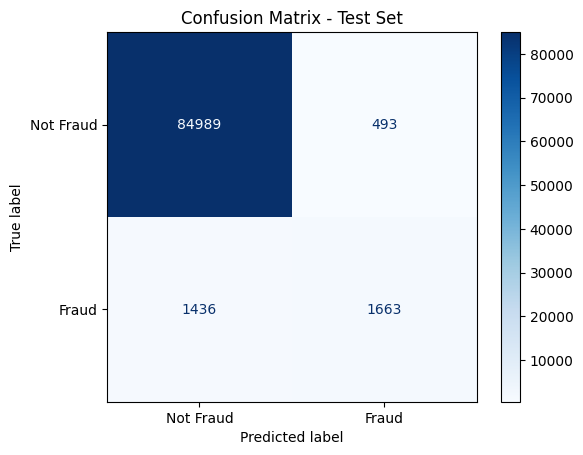

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99     85482
       Fraud       0.77      0.54      0.63      3099

    accuracy                           0.98     88581
   macro avg       0.88      0.77      0.81     88581
weighted avg       0.98      0.98      0.98     88581

True Negatives (TN): 84989
False Positives (FP): 493
False Negatives (FN): 1436
True Positives (TP): 1663


In [72]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_2.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

### Neural Network Model Instance 3:
  A deep neural network featuring L1 regularization and Dropout decreases exponentially across its hidden layers for binary classification. It's compiled with RMSprop and trained for 100 epochs, utilized an early stopping with a larger batch size.

In [84]:
dropout_rates = [0.2, 0.1, 0.1, 0.05, 0.0]

model_3 = build_model(
    input_dim=X_train_processed.shape[1],
    optimizer=RMSprop(learning_rate=0.0001),
    regularizer=l1(0.0001),
    dropout_rates=dropout_rates,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_3 = model_3.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    verbose=1
)

save_model(model_3, 'saved_models/nn_instance_3.keras')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9437 - loss: 0.3727 - val_accuracy: 0.9719 - val_loss: 0.2144
Epoch 2/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9698 - loss: 0.2030 - val_accuracy: 0.9721 - val_loss: 0.1634
Epoch 3/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9709 - loss: 0.1620 - val_accuracy: 0.9722 - val_loss: 0.1447
Epoch 4/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9712 - loss: 0.1462 - val_accuracy: 0.9726 - val_loss: 0.1342
Epoch 5/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9715 - loss: 0.1372 - val_accuracy: 0.9729 - val_loss: 0.1281
Epoch 6/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9714 - loss: 0.1323 - val_accuracy: 0.9725 - val_loss: 0.1260
Epoch 7/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9717 - loss: 0.1282 - val_accuracy: 0.9732 - val_loss: 0.1215
Epoch 8/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9719 -

#### Neural Network Model Instance 3 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step


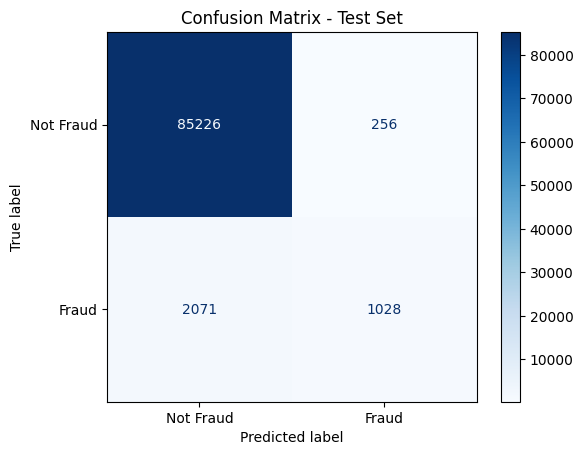

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.80      0.33      0.47      3099

    accuracy                           0.97     88581
   macro avg       0.89      0.66      0.73     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85226
False Positives (FP): 256
False Negatives (FN): 2071
True Positives (TP): 1028


In [85]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_3.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

### Neural Network Model Instance 4:
A deep neural network experimenting with SDG optimization and an L2 regularizer. no dropout rates but applied early_stoppping with 10 patience on val_loss.

In [86]:
model_4 = build_model(
    input_dim=X_train_processed.shape[1],
    optimizer=SGD(learning_rate=0.01),
    regularizer=l2(0.001),
    dropout_rates=None,
    use_batch_norm=False
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_4 = model_4.fit(
    X_train_processed, y_train,
    epochs=150,
    batch_size=150,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
save_model(model_4, 'saved_models/nn_instance_4.keras')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9617 - loss: 0.4397 - val_accuracy: 0.9691 - val_loss: 0.3615
Epoch 2/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9699 - loss: 0.3532 - val_accuracy: 0.9717 - val_loss: 0.3305
Epoch 3/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9712 - loss: 0.3243 - val_accuracy: 0.9720 - val_loss: 0.3054
Epoch 4/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9717 - loss: 0.2995 - val_accuracy: 0.9722 - val_loss: 0.2840
Epoch 5/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9717 - loss: 0.2799 - val_accuracy: 0.9722 - val_loss: 0.2659
Epoch 6/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9723 - loss: 0.2593 - val_accuracy: 0.9727 - val_loss: 0.2479
Epoch 7/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9721 - loss: 0.2446 - val_accuracy: 0.9727 - val_loss: 0.2323
Epoch 8/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9725 - loss: 0

#### Neural Network Model Instance 4 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


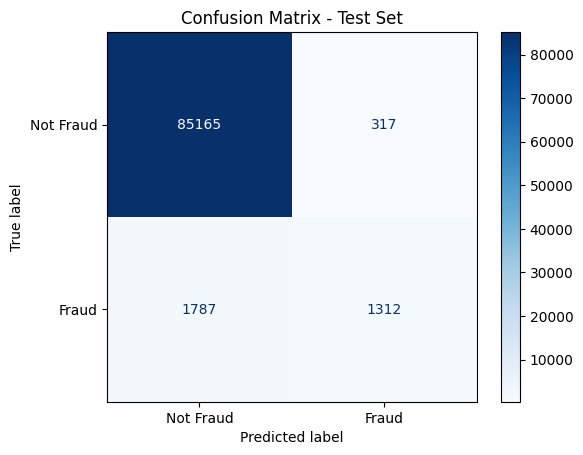

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.81      0.42      0.55      3099

    accuracy                           0.98     88581
   macro avg       0.89      0.71      0.77     88581
weighted avg       0.97      0.98      0.97     88581

True Negatives (TN): 85165
False Positives (FP): 317
False Negatives (FN): 1787
True Positives (TP): 1312


In [87]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_4.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Neural Network Model Instance 5:
A deep neural network Experimenting using Nadam optimization with a 0.001 learning rate used batchnormalization bewtween  each layer to normalize activation inputs and also no dropout applied and l2 regularization was used to prevent overfitting and finally early stopping was also applied same as in the previous models.

In [98]:
model_5 = build_model(
    input_dim=X_train_processed.shape[1],
    optimizer=Nadam(learning_rate=0.0001),
    regularizer=l2(0.0001),
    use_batch_norm=True
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_5 = model_5.fit(
    X_train_processed, y_train,
    epochs=300,
    batch_size=100,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Save the model
save_model(model_5, 'saved_models/nn_instance_5.keras')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7857 - loss: 0.5566 - val_accuracy: 0.9734 - val_loss: 0.1714
Epoch 2/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9728 - loss: 0.1497 - val_accuracy: 0.9741 - val_loss: 0.1179
Epoch 3/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9734 - loss: 0.1187 - val_accuracy: 0.9750 - val_loss: 0.1122
Epoch 4/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9742 - loss: 0.1126 - val_accuracy: 0.9756 - val_loss: 0.1091
Epoch 5/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9752 - loss: 0.1087 - val_accuracy: 0.9759 - val_loss: 0.1065
Epoch 6/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9759 - loss: 0.1058 - val_accuracy: 0.9762 - val_loss: 0.1050
Epoch 7/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9762 - loss: 0.1031 - val_accuracy: 0.9767 - val_loss: 0.1030
Epoch 8/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9769 -

#### Neural Network Model Instance 5 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step


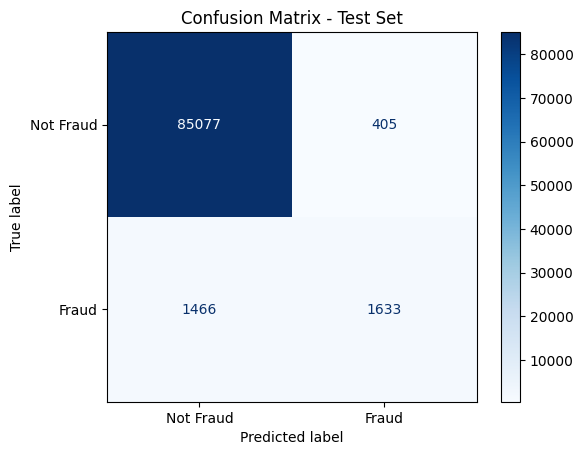

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.80      0.53      0.64      3099

    accuracy                           0.98     88581
   macro avg       0.89      0.76      0.81     88581
weighted avg       0.98      0.98      0.98     88581

True Negatives (TN): 85077
False Positives (FP): 405
False Negatives (FN): 1466
True Positives (TP): 1633


In [101]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_5.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [100]:
# Evaluation function
def evaluate_model(y_true, y_pred_prob):
    y_pred = (y_pred_prob > 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

# Get validation predictions
val_preds = {
    'Instance 1': model_1.predict(X_val_processed),
    'Instance 2': model_2.predict(X_val_processed),
    'Instance 3': model_3.predict(X_val_processed),
    'Instance 4': model_4.predict(X_val_processed),
    'Instance 5': model_5.predict(X_val_processed),
    'Instance 6': lgb_model.predict_proba(X_val_processed)[:, 1],
}

# Get test predictions (FIX: Instance 5 was using validation data)
test_preds = {
    'Instance 1': model_1.predict(X_test_processed),
    'Instance 2': model_2.predict(X_test_processed),
    'Instance 3': model_3.predict(X_test_processed),
    'Instance 4': model_4.predict(X_test_processed),
    'Instance 5': model_5.predict(X_test_processed),
    'Instance 6': lgb_model.predict_proba(X_test_processed)[:, 1],
}

# Evaluate
val_results = {k: evaluate_model(y_val, np.ravel(v)) for k, v in val_preds.items()}
test_results = {k: evaluate_model(y_test, np.ravel(v)) for k, v in test_preds.items()}

# Results printing function
def print_results(title, results):
    print(f"\n=== {title} ===")
    print(f"{'Instance':<12} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
    print("=" * 60)
    for instance, metrics in results.items():
        print(f"{instance:<12} "
              f"{metrics['accuracy']:<10.4f} "
              f"{metrics['f1']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f}")

# Print evaluation results
print_results("Validation Set Evaluation", val_results)
print_results("Test Set Evaluation", test_results)


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 761us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step


/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 673us/step


/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Validation Set Evaluation ===
Instance     Accuracy   F1 Score   Precision  Recall    
Instance 1   0.9728     0.4755     0.7288     0.3529    
Instance 2   0.9789     0.6423     0.7903     0.5410    
Instance 3   0.9742     0.4724     0.8310     0.3300    
Instance 4   0.9771     0.5683     0.8354     0.4306    
Instance 5   0.9792     0.6405     0.8108     0.5294    
Instance 6   0.9878     0.8188     0.8516     0.7884    

=== Test Set Evaluation ===
Instance     Accuracy   F1 Score   Precision  Recall    
Instance 1   0.9723     0.4723     0.7079     0.3543    
Instance 2   0.9782     0.6329     0.7713     0.5366    
Instance 3   0.9737     0.4691     0.8006     0.3317    
Instance 4   0.9762     0.5550     0.8054     0.4234    
Instance 5   0.9789     0.6358     0.8013     0.5269    
Instance 6   0.9873     0.8120     0.8445     0.7819    


# SECTION 3: Predictions on The Best Model
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [95]:
def make_predictions(model_path, X):
    """
    Loads a model from the given path and makes binary predictions on X.

    Parameters:
    - model_path: str, path to the saved Keras model (e.g., .h5 or .keras)
    - X: np.array or DataFrame, preprocessed input features

    Returns:
    - predictions: np.array of binary class labels (0 or 1)
    """

    # Load the model
    model = load_model(model_path)

    # Make probability predictions
    probas = model.predict(X)

    # Convert probabilities to binary labels (threshold 0.5)
    predictions = (probas > 0.5).astype(int).ravel()

    return predictions

In [97]:
best_model_path = 'saved_models/nn_instance_2.keras'
y_pred_test = make_predictions(best_model_path, X_test_processed)

print(classification_report(y_test, y_pred_test))

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     85482
           1       0.77      0.54      0.63      3099

    accuracy                           0.98     88581
   macro avg       0.88      0.77      0.81     88581
weighted avg       0.98      0.98      0.98     88581

